# Dataset Loading

In [ ]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 96% 638M/663M [00:04<00:00, 68.2MB/s]
100% 663M/663M [00:04<00:00, 152MB/s] 


In [ ]:
import zipfile
zf = "/content/tuberculosis-tb-chest-xray-dataset.zip"
target_dir = "/content/dataset/cnn/tuberculosis_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

splitfolders.ratio(
    "/content/dataset/cnn/tuberculosis_revamped/TB_Chest_Radiography_Database",
    output="/content/dataset/cnn/tuberculosis",
    seed=1337,
    ratio=(.7, .2, .1),
    group_prefix=None
)


Copying files: 4200 files [00:02, 1594.04 files/s]


In [ ]:
!rm -r "/content/dataset/cnn/tuberculosis_revamped"

In [ ]:
# !mv  -v /content/dataset/cnn/tuberculosis/test/Normal/* /content/dataset/cnn/tuberculosis/test/
# !mv  -v /content/dataset/cnn/tuberculosis/test/Tuberculosis/* /content/dataset/cnn/tuberculosis/test/
# !rm -r /content/dataset/cnn/tuberculosis/test/Normal
# !rm -r /content/dataset/cnn/tuberculosis/test/Tuberculosis

# Data preparation and Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/dataset/cnn/tuberculosis/train'
test_path = '/content/dataset/cnn/tuberculosis/test'
valid_path = '/content/dataset/cnn/tuberculosis/val'

In [ ]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                #shear_range = 0,
                                #zoom_range = 0,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 2939 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


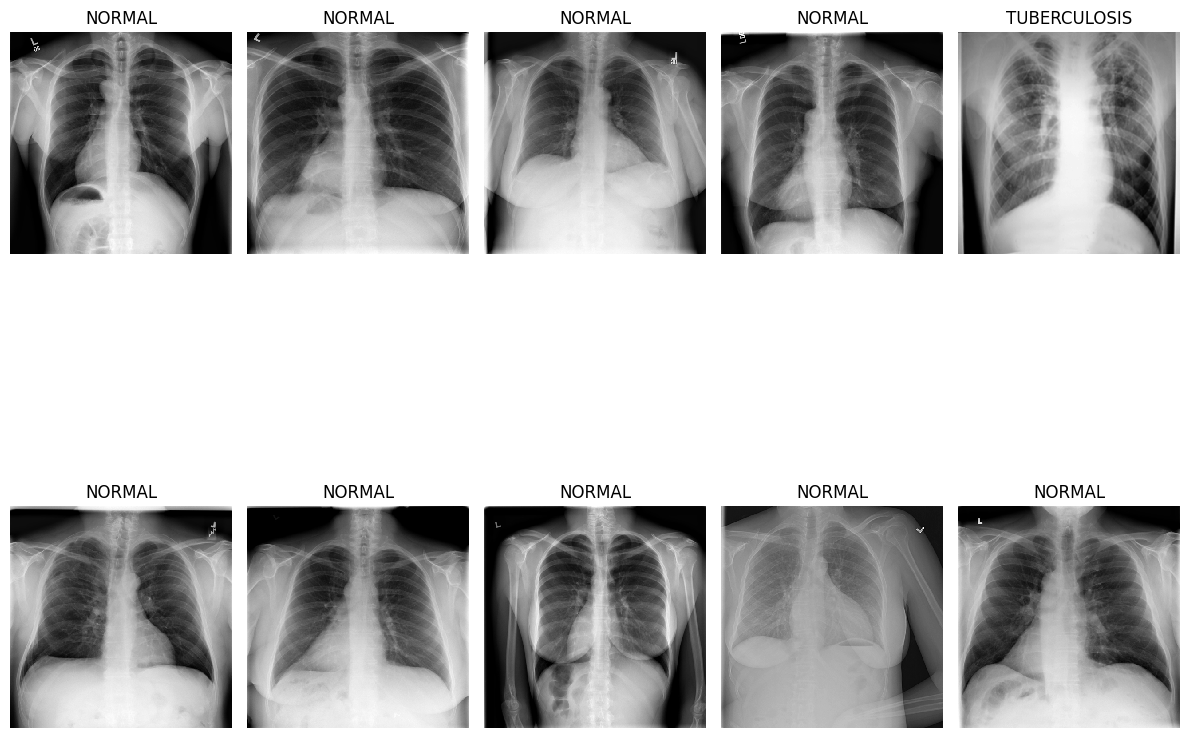

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# CNN-ConvLSTM model

In [ ]:
from tensorflow.keras import backend as K

model = Sequential()

# First CNN block for feature extraction
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

prev_layer_shape = K.int_shape(model.layers[-1].output)

# Use dynamic values for target shape calculation
target_shape = (1, prev_layer_shape[1], prev_layer_shape[2], prev_layer_shape[3])

# Reshape with dynamic target shape
model.add(Reshape(target_shape))

# ConvLSTM layer
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', return_sequences=True))

# Flatten and add fully-connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Adjust activation for your task

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_101 (MaxPool  (None, 24, 24, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_101 (Conv2D)         (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_102 (MaxPool  (None, 11, 11, 64)        0         
 ing2D)                                                          
                                                                 
 reshape_35 (Reshape)        (None, 1, 11, 11, 64)     0         
                                                                 
 conv_lstm2d_36 (ConvLSTM2D  (None, 1, 9, 9, 32)     

In [ ]:
cnn.output_shape

(None, 60, 60, 128)

In [ ]:
model.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
184/184 [==============================] - 231s 278ms/step - loss: 0.5086 - accuracy: 0.7958 - val_loss: 0.2345 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 2/25
184/184 [==============================] - 48s 259ms/step - loss: 0.2746 - accuracy: 0.8942 - val_loss: 0.2302 - val_accuracy: 0.9024 - lr: 0.0010
Epoch 3/25
184/184 [==============================] - 48s 259ms/step - loss: 0.1834 - accuracy: 0.9275 - val_loss: 0.2814 - val_accuracy: 0.8714 - lr: 0.0010
Epoch 4/25
184/184 [==============================] - 47s 253ms/step - loss: 0.1616 - accuracy: 0.9405 - val_loss: 0.1465 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 5/25
184/184 [==============================] - 48s 261ms/step - loss: 0.1286 - accuracy: 0.9530 - val_loss: 0.2473 - val_accuracy: 0.9083 - lr: 0.0010
Epoch 6/25
184/184 [==============================] - 47s 256ms/step - loss: 0.1504 - accuracy: 0.9462 - val_loss: 0.2348 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 7/25
184/184 [==============================]

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

27/27 [==============================] - 10s 364ms/step - loss: 0.2209 - accuracy: 0.9477
The testing accuracy is : 94.77434754371643 %


In [ ]:
preds = model.predict(test,verbose=1)

27/27 [==============================] - 9s 325ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

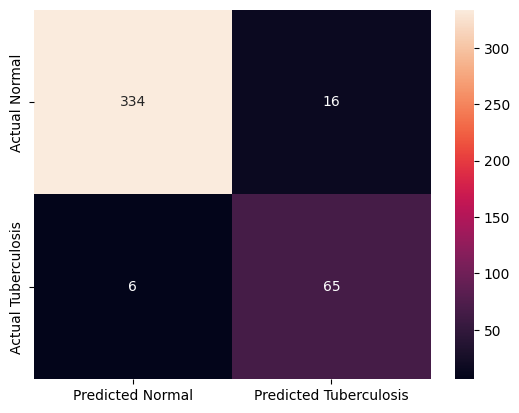

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.95      0.97       350
TUBERCULOSIS       0.80      0.92      0.86        71

    accuracy                           0.95       421
   macro avg       0.89      0.93      0.91       421
weighted avg       0.95      0.95      0.95       421



# Standard CNN-LSTM

In [ ]:
from tensorflow.keras import layers

# Define image dimensions (adjust based on your data)
img_height = 500  # Adjust image height
img_width = 500  # Adjust image width
num_channels = 1  # Grayscale images have 1 channel
timesteps = 10  # Number of frames in a sequence  # Adjust based on your data

# Define the CNN-LSTM model
model = Sequential()

# Expected input shape for the model (batch, timesteps, height, width, channels)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, num_channels)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Consider adding dropout for regularization (e.g., layers.Dropout(0.2))

# Flatten the output from the CNN block
model.add(layers.Flatten())
prev_layer_shape = K.int_shape(model.layers[-1].output)

# Use dynamic values for target shape calculation
target_shape = (8, prev_layer_shape[1]//8)
model.add(Reshape(target_shape))

# Standard LSTM layer for processing temporal information
model.add(layers.LSTM(64, return_sequences=True))  # Adjust units as needed

# Dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Adjust activation for your task

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_133 (Conv2D)         (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_133 (MaxPool  (None, 249, 249, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_134 (Conv2D)         (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_134 (MaxPool  (None, 123, 123, 64)      0         
 ing2D)                                                          
                                                                 
 flatten_51 (Flatten)        (None, 968256)            0         
                                                                 
 reshape_43 (Reshape)        (None, 8, 121032)       

In [ ]:
model.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
735/735 [==============================] - 55s 68ms/step - loss: 0.5745 - accuracy: 0.7210 - val_loss: 0.5862 - val_accuracy: 0.7155 - lr: 0.0010
Epoch 2/25
735/735 [==============================] - 50s 68ms/step - loss: 0.5242 - accuracy: 0.7237 - val_loss: 0.6732 - val_accuracy: 0.4679 - lr: 0.0010
Epoch 3/25
735/735 [==============================] - 50s 68ms/step - loss: 0.5330 - accuracy: 0.7258 - val_loss: 0.4616 - val_accuracy: 0.7024 - lr: 0.0010
Epoch 4/25
735/735 [==============================] - 47s 65ms/step - loss: 0.5314 - accuracy: 0.7509 - val_loss: 0.7843 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 5/25
735/735 [==============================] - 51s 69ms/step - loss: 0.5298 - accuracy: 0.6737 - val_loss: 0.3818 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 6/25
735/735 [==============================] - 49s 67ms/step - loss: 0.5227 - accuracy: 0.6652 - val_loss: 0.5763 - val_accuracy: 0.6476 - lr: 0.0010
Epoch 7/25
735/735 [==============================] - 49s 

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

106/106 [==============================] - 7s 66ms/step - loss: 0.4383 - accuracy: 0.7862
The testing accuracy is : 78.6223292350769 %


In [ ]:
preds = model.predict(test,verbose=1)

106/106 [==============================] - 8s 64ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

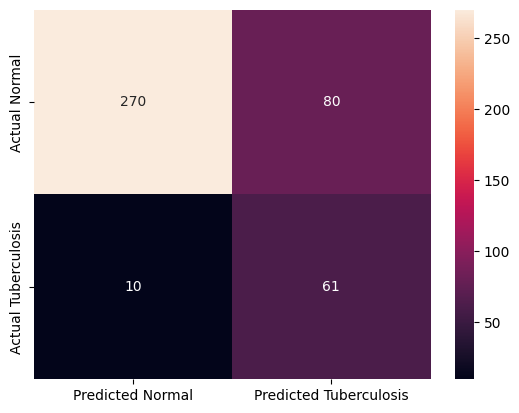

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.96      0.77      0.86       350
TUBERCULOSIS       0.43      0.86      0.58        71

    accuracy                           0.79       421
   macro avg       0.70      0.82      0.72       421
weighted avg       0.87      0.79      0.81       421

